In [1]:
from common import config
config.GPU =True

In [2]:
from common.config import GPU
GPU

True

In [3]:

if GPU: # GPU
    import cupy as np
    np.cuda.set_allocator(np.cuda.MemoryPool().malloc)
    #np.add.at = np.scatter_add

    print('\033[92m' + '-' * 60 + '\033[0m')
    print(' ' * 23 + '\033[92mGPU Mode (cupy)\033[0m')
    print('\033[92m' + '-' * 60 + '\033[0m\n')


# 4.3.1 CBOW 모델 구현


------------------------------------------------------------
                       GPU Mode (cupy)
------------------------------------------------------------



In [4]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[np.asnumpy(idx)] # numpy 일텐데 idx가 cupy.core~ array라서
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.scatter_add(dW, self.idx, dout)
        return None

In [5]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 정답 데이터가 원핫 벡터일 경우 정답 레이블 인덱스로 변환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None  # sigmoid의 출력
        self.t = None  # 정답 데이터

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx


In [6]:
# coding: utf-8
# from common.np import *  # import numpy as np
#from common.layers import SigmoidWithLoss
import collections

class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None

    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)

        self.cache = (h, target_W)
        return out

    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh


class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = np.asnumpy(target[i])
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        else:
            # GPU(cupy）로 계산할 때는 속도를 우선한다.
            # 부정적 예에 타깃이 포함될 수 있다.
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample


class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        # 긍정적 예 순전파
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        # 부정적 예 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss

    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh


In [7]:

import sys
sys.path.append('D:/ANACONDA/envs/tf-gpu/code/NLP')
#import cupy as np
#from common.layers import Embedding
#from common.negative_sampling_layer import NegativeSamplingLoss

class CBOW:
    def __init__(self, vocab_size,hidden_size,window_size, corpus):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V,H).astype('f')
        W_out = 0.01 * np.random.rand(V,H).astype('f')
        
        # 계층 생성
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out,corpus, power=0.75, sample_size=5)
        
        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [],[]
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        #인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in
    
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:,i])
        h *= 1/ len(self.in_layers)
        loss = self.ns_loss.forward(h,target)
        return loss
    
    def backward(self, dout = 1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None
    
# Skip-Gram
class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        W_in = 0.01 * rn(V, H).astype('f')
        W_out = 0.01 * rn(V, H).astype('f')

        # 계층 생성
        self.in_layer = Embedding(W_in)
        self.loss_layers = []
        for i in range(2 * window_size):
            layer = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
            self.loss_layers.append(layer)

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer] + self.loss_layers
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)

        loss = 0
        for i, layer in enumerate(self.loss_layers):
            loss += layer.forward(h, contexts[:, i])
        return loss

    def backward(self, dout=1):
        dh = 0
        for i, layer in enumerate(self.loss_layers):
            dh += layer.backward(dout)
        self.in_layer.backward(dh)
        return None

In [8]:
# from common.trainer import Trainer
import numpy
import time
import matplotlib.pyplot as plt
#from common.np import *  # import numpy as np
#from common.util import clip_grads
def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate
class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=500):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # 뒤섞기
            idx = numpy.random.permutation(numpy.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 기울기 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 평가
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    
                    print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 손실 %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('반복 (x' + str(self.eval_interval) + ')')
        plt.ylabel('손실')
        plt.show()

#import sys
#sys.path.append('..')

def remove_duplicate(params, grads):
    '''
    매개변수 배열 중 중복되는 가중치를 하나로 모아
    그 가중치에 대응하는 기울기를 더한다.
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 가중치 공유 시
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 경사를 더함
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 가중치를 전치행렬로 공유하는 경우(weight tying)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads


In [9]:
# 4.3.2 CBOW 모델 학습 코드

#from common import config
#config.GPU = True # pip install cupy-cuda92  -----> for windows 10 # 위에서 했고
import pickle
#from common.trainer import Trainer
#from common.optimizer import Adam
class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

#from cbow import CBOW
#from common.util import create_contexts_target, to_cpu, to_gpu
def create_contexts_target(corpus, window_size=1):
    '''맥락과 타깃 생성

    :param corpus: 말뭉치(단어 ID 목록)
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return:
    '''
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)


def to_cpu(x):
    import numpy
    if type(x) == numpy.ndarray:
        return x
    return np.asnumpy(x)


def to_gpu(x):
    import cupy
    if type(x) == cupy.ndarray:
        return x
    return cupy.asarray(x)

from dataset import ptb

# 하이퍼 파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 데이터 읽기 + target, contexts 만들기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 501 / 9295 | 시간 8[s] | 손실 3.17
| 에폭 1 |  반복 1001 / 9295 | 시간 15[s] | 손실 2.62
| 에폭 1 |  반복 1501 / 9295 | 시간 23[s] | 손실 2.57
| 에폭 1 |  반복 2001 / 9295 | 시간 31[s] | 손실 2.53
| 에폭 1 |  반복 2501 / 9295 | 시간 40[s] | 손실 2.50
| 에폭 1 |  반복 3001 / 9295 | 시간 47[s] | 손실 2.48
| 에폭 1 |  반복 3501 / 9295 | 시간 56[s] | 손실 2.47
| 에폭 1 |  반복 4001 / 9295 | 시간 64[s] | 손실 2.44
| 에폭 1 |  반복 4501 / 9295 | 시간 72[s] | 손실 2.43
| 에폭 1 |  반복 5001 / 9295 | 시간 80[s] | 손실 2.40
| 에폭 1 |  반복 5501 / 9295 | 시간 88[s] | 손실 2.38
| 에폭 1 |  반복 6001 / 9295 | 시간 96[s] | 손실 2.36
| 에폭 1 |  반복 6501 / 9295 | 시간 104[s] | 손실 2.34
| 에폭 1 |  반복 7001 / 9295 | 시간 112[s] | 손실 2.33
| 에폭 1 |  반복 7501 / 9295 | 시간 120[s] | 손실 2.32
| 에폭 1 |  반복 8001 / 9295 | 시간 128[s] | 손실 2.30
| 에폭 1 |  반복 8501 / 9295 | 시간 136[s] | 손실 2.28
| 에폭 1 |  반복 9001 / 9295 | 시간 144[s] | 손실 2.28
| 에폭 2 |  반복 1 / 9295 | 시간 148[s] | 손실 2.27
| 에폭 2 |  반복 501 / 9295 | 시간 157[s] | 손실 2.22
| 에폭 2 |  반복 1001 / 9295 | 시간 165[s]

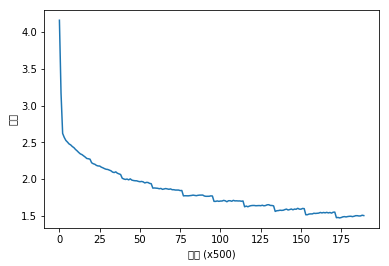

In [34]:
# 모델 등 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model,optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size) # eval_interval=500
trainer.plot()

In [35]:
word_vecs = model.word_vecs
if config.GPU :
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file,'wb') as f:
    pickle.dump(params,f,-1);

In [39]:
type(word_vecs)

numpy.ndarray

In [9]:
# 4.3.3 CBOW 모델 평가
# GPU -> CPU, cupy -> numpy 로
#from common.util import most_similar, analogy
import numpy as np
def cos_similarity(x, y, eps=1e-8):
    '''코사인 유사도 산출

    :param x: 벡터
    :param y: 벡터
    :param eps: '0으로 나누기'를 방지하기 위한 작은 값
    :return:
    '''
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)

def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    '''유사 단어 검색

    :param query: 쿼리(텍스트)
    :param word_to_id: 단어에서 단어 ID로 변환하는 딕셔너리
    :param id_to_word: 단어 ID에서 단어로 변환하는 딕셔너리
    :param word_matrix: 단어 벡터를 정리한 행렬. 각 행에 해당 단어 벡터가 저장되어 있다고 가정한다.
    :param top: 상위 몇 개까지 출력할 지 지정
    '''
    if query not in word_to_id:
        print('%s(을)를 찾을 수 없습니다.' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    # 코사인 유사도 계산
    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    # 코사인 유사도를 기준으로 내림차순으로 출력
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

def analogy(a, b, c, word_to_id, id_to_word, word_matrix, top=5, answer=None):
    for word in (a, b, c):
        if word not in word_to_id:
            print('%s(을)를 찾을 수 없습니다.' % word)
            return

    print('\n[analogy] ' + a + ':' + b + ' = ' + c + ':?')
    a_vec, b_vec, c_vec = word_matrix[word_to_id[a]], word_matrix[word_to_id[b]], word_matrix[word_to_id[c]]
    query_vec = b_vec - a_vec + c_vec
    query_vec = normalize(query_vec)

    similarity = np.dot(word_matrix, query_vec)

    if answer is not None:
        print("==>" + answer + ":" + str(np.dot(word_matrix[word_to_id[answer]], query_vec)))

    count = 0
    for i in (-1 * similarity).argsort():
        if np.isnan(similarity[i]):
            continue
        if id_to_word[i] in (a, b, c):
            continue
        print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

pkl_file = './cbow_params.pkl'
with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    
word_vecs = params['word_vecs']
word_to_id = params['word_to_id']
id_to_word = params['id_to_word']

# 가장 비슷한(most similar) 단어 뽑기
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.75537109375
 i: 0.74560546875
 they: 0.61572265625
 your: 0.6083984375
 anything: 0.59912109375

[query] year
 month: 0.8330078125
 summer: 0.76904296875
 week: 0.7529296875
 spring: 0.75
 decade: 0.70654296875

[query] car
 truck: 0.6533203125
 luxury: 0.60400390625
 window: 0.59423828125
 auto: 0.5908203125
 merkur: 0.5771484375

[query] toyota
 honda: 0.67333984375
 marathon: 0.65234375
 supermarkets: 0.6357421875
 seita: 0.6357421875
 chevrolet: 0.6298828125


In [10]:

def normalize(x):
    if x.ndim == 2:
        s = np.sqrt((x * x).sum(1))
        x /= s.reshape((s.shape[0], 1))
    elif x.ndim == 1:
        s = np.sqrt((x * x).sum())
        x /= s
    return x


In [11]:
# 유추(analogy) 작업
print('-'*50)
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)

--------------------------------------------------

[analogy] king:man = queen:?
 woman: 4.97265625
 yard: 4.78515625
 hacker: 4.7734375
 carolinas: 4.76171875
 downside: 4.73828125

[analogy] take:took = go:?
 eurodollars: 6.15625
 're: 4.51953125
 came: 4.4765625
 went: 4.46875
 were: 4.44140625

[analogy] car:cars = child:?
 a.m: 7.0234375
 daffynition: 5.94140625
 rape: 5.72265625
 women: 5.27734375
 incest: 5.24609375

[analogy] good:better = bad:?
 rather: 5.5546875
 more: 5.55078125
 less: 5.4140625
 greater: 4.34375
 worse: 3.744140625


# Skip Gram

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 41.59
| 에폭 1 |  반복 2001 / 9295 | 시간 217[s] | 손실 28.18
| 에폭 1 |  반복 4001 / 9295 | 시간 433[s] | 손실 25.10
| 에폭 1 |  반복 6001 / 9295 | 시간 650[s] | 손실 24.64
| 에폭 1 |  반복 8001 / 9295 | 시간 867[s] | 손실 24.41
| 에폭 2 |  반복 1 / 9295 | 시간 1007[s] | 손실 24.28
| 에폭 2 |  반복 2001 / 9295 | 시간 1222[s] | 손실 24.07
| 에폭 2 |  반복 4001 / 9295 | 시간 1438[s] | 손실 24.02
| 에폭 2 |  반복 6001 / 9295 | 시간 1654[s] | 손실 23.95
| 에폭 2 |  반복 8001 / 9295 | 시간 1869[s] | 손실 23.90
| 에폭 3 |  반복 1 / 9295 | 시간 2009[s] | 손실 23.85
| 에폭 3 |  반복 2001 / 9295 | 시간 2224[s] | 손실 23.61
| 에폭 3 |  반복 4001 / 9295 | 시간 2439[s] | 손실 23.61
| 에폭 3 |  반복 6001 / 9295 | 시간 2653[s] | 손실 23.60
| 에폭 3 |  반복 8001 / 9295 | 시간 2870[s] | 손실 23.59
| 에폭 4 |  반복 1 / 9295 | 시간 3008[s] | 손실 23.58
| 에폭 4 |  반복 2001 / 9295 | 시간 3224[s] | 손실 23.30
| 에폭 4 |  반복 4001 / 9295 | 시간 3438[s] | 손실 23.34
| 에폭 4 |  반복 6001 / 9295 | 시간 3651[s] | 손실 23.35
| 에폭 4 |  반복 8001 / 9295 | 시간 3864[s] | 손실 23.37
| 에폭 5 |  반복 1 / 9295 | 시간 4002[s] | 손실

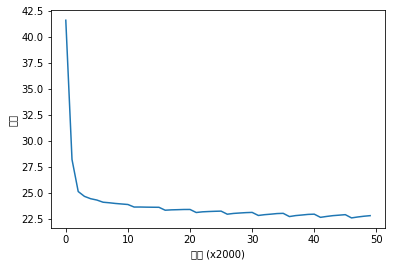

In [10]:
# 모델 등 생성
model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model,optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size,eval_interval=2000)
trainer.plot()

In [11]:
word_vecs = model.word_vecs
if config.GPU :
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'skipgram_params.pkl'
with open(pkl_file,'wb') as f:
    pickle.dump(params,f,-1);

In [12]:
# 4.3.3 CBOW 모델 평가
# GPU -> CPU, cupy -> numpy 로
#from common.util import most_similar, analogy
import numpy as np
def cos_similarity(x, y, eps=1e-8):
    '''코사인 유사도 산출

    :param x: 벡터
    :param y: 벡터
    :param eps: '0으로 나누기'를 방지하기 위한 작은 값
    :return:
    '''
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)

def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    '''유사 단어 검색

    :param query: 쿼리(텍스트)
    :param word_to_id: 단어에서 단어 ID로 변환하는 딕셔너리
    :param id_to_word: 단어 ID에서 단어로 변환하는 딕셔너리
    :param word_matrix: 단어 벡터를 정리한 행렬. 각 행에 해당 단어 벡터가 저장되어 있다고 가정한다.
    :param top: 상위 몇 개까지 출력할 지 지정
    '''
    if query not in word_to_id:
        print('%s(을)를 찾을 수 없습니다.' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    # 코사인 유사도 계산
    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    # 코사인 유사도를 기준으로 내림차순으로 출력
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

def analogy(a, b, c, word_to_id, id_to_word, word_matrix, top=5, answer=None):
    for word in (a, b, c):
        if word not in word_to_id:
            print('%s(을)를 찾을 수 없습니다.' % word)
            return

    print('\n[analogy] ' + a + ':' + b + ' = ' + c + ':?')
    a_vec, b_vec, c_vec = word_matrix[word_to_id[a]], word_matrix[word_to_id[b]], word_matrix[word_to_id[c]]
    query_vec = b_vec - a_vec + c_vec
    query_vec = normalize(query_vec)

    similarity = np.dot(word_matrix, query_vec)

    if answer is not None:
        print("==>" + answer + ":" + str(np.dot(word_matrix[word_to_id[answer]], query_vec)))

    count = 0
    for i in (-1 * similarity).argsort():
        if np.isnan(similarity[i]):
            continue
        if id_to_word[i] in (a, b, c):
            continue
        print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

def normalize(x):
    if x.ndim == 2:
        s = np.sqrt((x * x).sum(1))
        x /= s.reshape((s.shape[0], 1))
    elif x.ndim == 1:
        s = np.sqrt((x * x).sum())
        x /= s
    return x

pkl_file = './skipgram_params.pkl'
with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    
word_vecs = params['word_vecs']
word_to_id = params['word_to_id']
id_to_word = params['id_to_word']

# 가장 비슷한(most similar) 단어 뽑기
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

# 유추(analogy) 작업
print('-'*50)
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)


[query] you
 i: 0.67236328125
 your: 0.64990234375
 yourself: 0.642578125
 weird: 0.62939453125
 we: 0.61279296875

[query] year
 month: 0.6357421875
 earlier: 0.61572265625
 week: 0.5498046875
 summer: 0.505859375
 tons: 0.50048828125

[query] car
 luxury: 0.60986328125
 merkur: 0.595703125
 auto: 0.56396484375
 cars: 0.56298828125
 mazda: 0.552734375

[query] toyota
 lexus: 0.68115234375
 motor: 0.6787109375
 infiniti: 0.65771484375
 honda: 0.63330078125
 beretta: 0.58984375
--------------------------------------------------

[analogy] king:man = queen:?
 candlestick: 1.71484375
 bikers: 1.7080078125
 yard: 1.69921875
 ghost: 1.673828125
 artist: 1.6669921875

[analogy] take:took = go:?
 pricings: 2.013671875
 ran: 1.669921875
 feet: 1.64453125
 runs: 1.580078125
 stands: 1.55078125

[analogy] car:cars = child:?
 adults: 2.26171875
 rape: 2.1953125
 incest: 1.8408203125
 districts: 1.775390625
 priced: 1.763671875

[analogy] good:better = bad:?
 comparable: 1.556640625
 harm: 1.5175

In [ ]:
# 4.3.3 CBOW 모델 평가
# GPU -> CPU, cupy -> numpy 로
#from common.util import most_similar, analogy
import numpy as np

pkl_file = './skipgram_params.pkl'
with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    
word_vecs = params['word_vecs']
word_to_id = params['word_to_id']
id_to_word = params['id_to_word']

# 가장 비슷한(most similar) 단어 뽑기
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

# 유추(analogy) 작업
print('-'*50)
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)